# Estimate the SNR from the CFIS W3 stars

In [128]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import galsim

import itertools

import glob

%pylab inline


Populating the interactive namespace from numpy and matplotlib


# Build simulated dataset to test SNR estimator

In [12]:

# Define the ellipticities for each stars (e1s and e2s), 
# and the constant shape of the stars before the shearing (sigma, fwhm_psf)
e1 = np.linspace(-0.15, 0.15, num=10, endpoint=True)
e2 = np.linspace(-0.15, 0.15, num=10, endpoint=True)
R2 = np.random.uniform(2.5, 8, 10)
sigma = np.sqrt(R2/2)
fwhm_psf = (2*np.sqrt(2*np.log(2)))*sigma

# Generate the 1000 combinations of e1, e2 and fwhm

es = list(itertools.product(*[e1, e2, fwhm_psf]))
e1s = np.array([a for a,b,c in es])
e2s = np.array([b for a,b,c in es]) 
fwhms = np.array([c for a,b,c in es])



In [13]:
# Parameters
image_size = 51
psf_flux = 1.
beta_psf =  4.8 # 4.8# 2.5
pix_scale = 0.187
# desired_SNR = 30
desired_SNR = np.random.rand(e1s.shape[0])*190 + 10  # Going from 10 to 200

# Generate the vignets
new_vignets_with_noise = np.zeros((e1s.shape[0],image_size,image_size))
new_e1_HSM = np.zeros(e1s.shape)
new_e2_HSM = np.zeros(e1s.shape)
new_R2_HSM = np.zeros(e1s.shape)
for it in range(e1s.shape[0]):
    
    # PSF generation. Define size
    psf = galsim.Moffat(fwhm=fwhms[it]*pix_scale, beta=beta_psf)
#     psf = galsim.Gaussian(fwhm=fwhms[it]*pix_scale)#, beta=beta_psf)
    # Define the Flux
    psf = psf.withFlux(psf_flux)
    # Define the shear
    psf = psf.shear(g1=e1s[it], g2=e2s[it])
    # Draw the PSF on a vignet
    noisy_image_epsf = galsim.ImageF(image_size, image_size)
    # Define intrapixel shift (uniform distribution in [-0.5,0.5])
    rand_shift = np.random.rand(2)-0.5
    psf.drawImage(image=noisy_image_epsf, offset=rand_shift, scale=pix_scale)

    sigma_noise = np.sqrt((np.sum(noisy_image_epsf.array**2))/(desired_SNR[it] * image_size**2))
    # Generate Gaussian noise for the PSF 
    gaussian_noise = galsim.GaussianNoise(sigma=sigma_noise)
    
    # Before adding the noise, we measure the ellipticity components
#     my_moments = noisy_image_epsf.FindAdaptiveMom()
    my_moments = galsim.hsm.FindAdaptiveMom(noisy_image_epsf)
    new_e1_HSM[it] = my_moments.observed_shape.g1
    new_e2_HSM[it] = my_moments.observed_shape.g2
    new_R2_HSM[it] = my_moments.moments_sigma
    
    # Add Gaussian noise to the PSF 
    noisy_image_epsf.addNoise(gaussian_noise)
    
    new_vignets_with_noise[it,:,:] = noisy_image_epsf.array
    
    

# Calculate the SNR

In [74]:

it_image = 20
image = new_vignets_with_noise[it_image,:,:]


In [75]:
# Calculate star flux
my_moments = galsim.hsm.FindAdaptiveMom(galsim.Image(image))
star_flux = my_moments.moments_amp
star_flux

0.9388303756713867

In [76]:
# Calculate noise std dev

# Calculate window function
obs_centroid = [my_moments.moments_centroid.x, my_moments.moments_centroid.y]
obs_sigma = my_moments.moments_sigma



In [80]:
# Draw a window function with the sigma and the centroid

window = np.ones(image.shape, dtype=bool)


for coord_x in range(image.shape[0]):
    for coord_y in range(image.shape[1]):
        
        if np.sqrt((coord_x - obs_centroid[0])**2 + (coord_y - obs_centroid[1])**2) <= 5*obs_sigma :
            window[coord_x, coord_y] = False

            

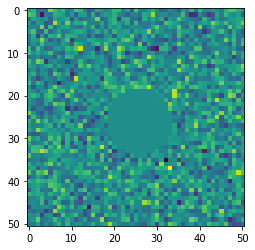

In [83]:
imshow(window*image)

In [87]:
np.sum(image[window])

0.027629097013395665

## SNR definition

$$SNR = \frac{\| y\|_{2}^{2}}{\sigma^{2} p^{2}}, $$

where $y$ is the image postage stamp consisting of $p^{2}$ pixels. Considering a star with additive Gaussian noise of standard deviation $\sigma$.

We approximate the SNR




In [120]:
def mad(x):
    r"""Compute an estimation of the standard deviation 
    of a Gaussian distribution using the robust 
    MAD (Median Absolute Deviation) estimator."""
    return 1.4826*np.median(np.abs(x - np.median(x)))


def SNR_estimator(image):
    
    # Use adaptive moments estimator
    my_moments = galsim.hsm.FindAdaptiveMom(galsim.Image(image))
    # Calculate star flux
    star_flux = my_moments.moments_amp

    
    obs_centroid = [my_moments.moments_centroid.x, my_moments.moments_centroid.y]
    obs_sigma = my_moments.moments_sigma
    
    # Calculate window function for estimating the noise
    # Taking 5*sigma we are probably cutting all the flux from the star
    window = np.ones(image.shape, dtype=bool)
    
    for coord_x in range(image.shape[0]):
        for coord_y in range(image.shape[1]):
            if np.sqrt((coord_x - obs_centroid[0])**2 + (coord_y - obs_centroid[1])**2) <= 5*obs_sigma :
                window[coord_x, coord_y] = False
    
    # Calculate noise std dev
    noise_std_dev = mad(image[window])
    
    # Calculate star power
    star_power = np.sum(image[~window]**2)

    # Estimate the SNR
    SNR_est = star_power/(noise_std_dev**2 * image.shape[0]*image.shape[1])
    
    return SNR_est


## Check out results with the simulated images

In [121]:

estimated_SNR = np.array([SNR_estimator(_im) for _im in new_vignets_with_noise])


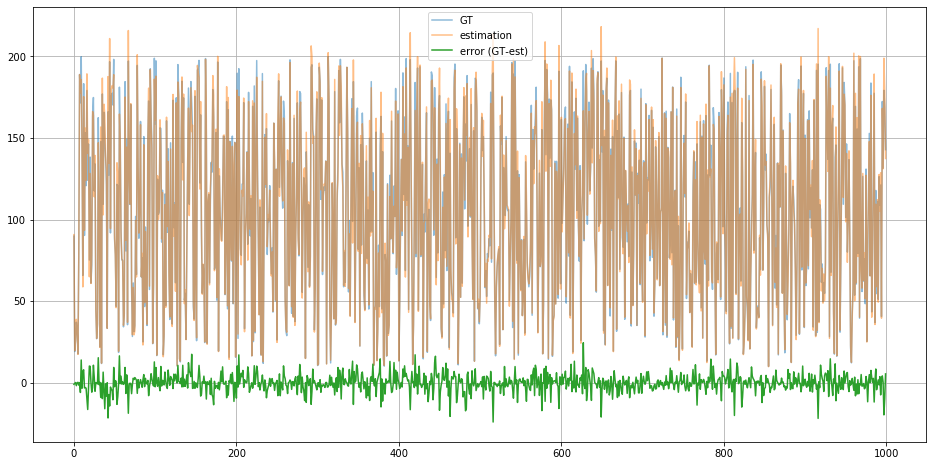

In [134]:
figure(figsize=(16,8))
plot(desired_SNR, label='GT', alpha=0.5)
plot(estimated_SNR, label='estimation', alpha=0.5)
plot(desired_SNR-estimated_SNR, label='error (GT-est)')
legend()
grid()
show()

# Now calculate the SNR of the real stars

In [159]:
# Folder with all the CFIS images of W3 (area=50deg^2)
CFIS_directory = '/Users/tliaudat/Documents/PhD/codes/venv_p3/JB-data/CFIS-data/all_w3_star_cat/'

file_list = glob.glob(CFIS_directory + '*.fits')

In [160]:

full_SNR_list = []
# Stupid SExtractor mask for pixels
thresh = -1e5

for it in range(num_files):
    # Open file
    starcat = fits.open(file_list[it])[2].data['VIGNET']
    
    starcat[starcat < thresh] = 0
    try:
        # Calculate SNR to stars
        file_SNR_est = [SNR_estimator(_star) for _star in starcat]
        # Save SNRs
        full_SNR_list.append(file_SNR_est)
    except:
        pass


/Users/tliaudat/opt/anaconda3/envs/mccd_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tliaudat/opt/anaconda3/envs/mccd_env/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [161]:
full_SNR = list(itertools.chain.from_iterable(full_SNR_list))


In [162]:
len(full_SNR)

535417

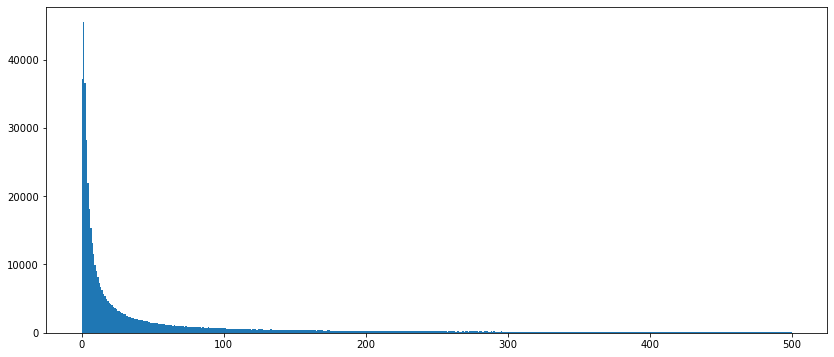

In [172]:

plt.figure(figsize=(14,6))
plt.hist(full_SNR, bins=500, range=[0, 500])
plt.show()

In [165]:
full_SNR_array = np.array(full_SNR)

In [167]:
np.save('./full_SNR.npy', full_SNR_array)